# Data
- Occupations by State and Likelihood of Automation: https://data.world/wnedds/occupations-by-state-and-likelihood-of-automation
- Wage by Occupation: https://data.world/quanticdata/occupation-and-salary-by-state-and-likelihood-of-automation/workspace/file?filename=national_M2016_dl.xlsx

# Data Handling (ingestion/cleaning/creation)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import patsy
from scipy.stats import normaltest
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

In [2]:
df_occ = pd.read_csv('../datasets/raw_state_automation_data.csv', encoding='cp1252')
df_wages = pd.read_excel('../datasets/wagedata.xlsx')

In [3]:
df_wages.head()

,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,H_MEAN,A_MEAN,MEAN_PRSE,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,00-0000,All Occupations,total,140400040,0.1,23.86,49630,0.1,9.27,11.6,17.81,28.92,45.45,19290,24140,37040,60150,94540,NaN,NaN
1,11-0000,Management Occupations,major,7090790,0.2,56.74,118020,0.1,22.76,32.99,48.46,70.72,#,47330,68630,100790,147090,#,NaN,NaN
2,11-1000,Top Executives,minor,2465800,0.2,61.03,126950,0.2,20.58,31.45,49.19,78.35,#,42810,65420,102320,162970,#,NaN,NaN
3,11-1010,Chief Executives,broad,223260,0.7,93.44,194350,0.4,33.55,54.86,87.12,#,#,69780,114100,181210,#,#,NaN,NaN
4,11-1011,Chief Executives,detailed,223260,0.7,93.44,194350,0.4,33.55,54.86,87.12,#,#,69780,114100,181210,#,#,NaN,NaN


In [4]:
df_occ = df_occ[['SOC', 'Occupation', 'Probability']]

In [5]:
df = pd.merge(df_occ, df_wages, how='left', left_on='SOC', right_on='OCC_CODE')

In [6]:
df.head()

,SOC,Occupation,Probability,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,H_MEAN,A_MEAN,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,11-1011,Chief Executives,0.015,11-1011,Chief Executives,detailed,223260.0,0.7,93.44,194350,...,87.12,#,#,69780,114100,181210,#,#,NaN,NaN
1,11-1021,General and Operations Managers,0.160,11-1021,General and Operations Managers,detailed,2188870.0,0.3,58.7,122090,...,47.74,74.53,#,44290,64890,99310,155020,#,NaN,NaN
2,11-2011,Advertising and Promotions Managers,0.039,11-2011,Advertising and Promotions Managers,detailed,28860.0,2.3,56.64,117810,...,48.47,70.98,#,44950,67000,100810,147640,#,NaN,NaN
3,11-2021,Marketing Managers,0.014,11-2021,Marketing Managers,detailed,205900.0,1.0,69.3,144140,...,63.07,85.91,#,67490,93200,131180,178690,#,NaN,NaN
4,11-2022,Sales Managers,0.013,11-2022,Sales Managers,detailed,365230.0,0.6,64.95,135090,...,56.71,80.91,#,55790,79420,117960,168300,#,NaN,NaN


In [7]:
# See what we're dealing with
print('A_Mean: {}'.format(df.A_MEAN.unique()))
print('A_Median: {}'.format(df.A_MEDIAN.unique()))

A_Mean: [194350 122090 117810 144140 135090 123360 98930 145740 139720 107060
 117720 97630 126900 120210 115180 75790 99510 52150 95390 105770 143870
 56010 79690 59410 109370 136150 71980 70290 70870 78060 112150 86560
 63910 60040 67420 64990 65930 70250 66620 47290 nan 77810 91910 52020
 66490 63350 70620 74870 76730 58030 77170 81160 97640 123100 75480 88940
 49480 76260 57950 45340 76230 116320 91620 85180 104300 110590 87130
 84500 56600 114120 105600 84340 85160 58490 84470 68820 66160 63480
 112010 77330 89970 105420 89730 118700 98620 103760 88530 90190 99860
 97050 89800 103010 105950 147030 99250 54290 63390 57480 71070 52120
 62950 57860 52500 56920 57180 64050 45490 72890 71270 69290 94340 76850
 64890 77830 65130 60300 77720 95000 110380 121770 94840 80820 101570
 75360 106390 83740 98460 112860 59950 78690 104570 94650 86840 73060
 66440 74090 60990 112250 80860 40470 46130 49770 62240 77820 46820 47930
 60690 38630 49270 44160 57620 54090 46050 38740 47510 55510 47880 

In [8]:
# Drop rows if no mean wage info
df = df[df.A_MEAN != '*']
df = df[df.A_MEDIAN != '#']
df.dropna(inplace=True,subset=['A_MEAN', 'A_MEDIAN'])

df.reset_index(drop=True)

,SOC,Occupation,Probability,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,H_MEAN,A_MEAN,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,11-1011,Chief Executives,0.015,11-1011,Chief Executives,detailed,223260.0,0.7,93.44,194350,...,87.12,#,#,69780,114100,181210,#,#,NaN,NaN
1,11-1021,General and Operations Managers,0.160,11-1021,General and Operations Managers,detailed,2188870.0,0.3,58.7,122090,...,47.74,74.53,#,44290,64890,99310,155020,#,NaN,NaN
2,11-2011,Advertising and Promotions Managers,0.039,11-2011,Advertising and Promotions Managers,detailed,28860.0,2.3,56.64,117810,...,48.47,70.98,#,44950,67000,100810,147640,#,NaN,NaN
3,11-2021,Marketing Managers,0.014,11-2021,Marketing Managers,detailed,205900.0,1.0,69.3,144140,...,63.07,85.91,#,67490,93200,131180,178690,#,NaN,NaN
4,11-2022,Sales Managers,0.013,11-2022,Sales Managers,detailed,365230.0,0.6,64.95,135090,...,56.71,80.91,#,55790,79420,117960,168300,#,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,53-7072,Pump Operators; Except Wellhead Pumpers,0.900,53-7072,"Pump Operators, Except Wellhead Pumpers",detailed,12030.0,8.7,22.24,46270,...,20.42,28.15,35.46,26600,32200,42470,58560,73750,NaN,NaN
678,53-7073,Wellhead Pumpers,0.840,53-7073,Wellhead Pumpers,detailed,11610.0,5.2,24.39,50730,...,23.85,30.05,36.35,27940,36630,49610,62500,75610,NaN,NaN
679,53-7081,Refuse and Recyclable Material Collectors,0.930,53-7081,Refuse and Recyclable Material Collectors,detailed,114680.0,1.5,18.12,37690,...,16.95,22.43,29.09,20650,26090,35270,46650,60500,NaN,NaN
680,53-7111,Mine Shuttle Car Operators,0.370,53-7111,Mine Shuttle Car Operators,detailed,1590.0,7.0,27.1,56370,...,27.14,29.91,32.73,44120,49880,56450,62200,68080,NaN,NaN


In [9]:
# Rest of values should be numeric, so transform
df.A_MEAN = pd.to_numeric(df.A_MEAN)
df.A_MEDIAN = pd.to_numeric(df.A_MEDIAN)

# Data Visualization

## Mean Annual Income

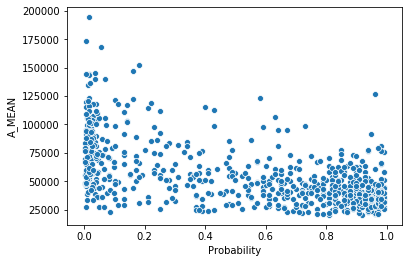

In [10]:
sns.scatterplot(df.Probability, df.A_MEAN)

In [11]:
# Test normality of wage
stat_wage_mean, p_wage_mean = normaltest(df.A_MEAN)
print('mean wage is normally distributed') if p_wage_mean < 0.01 else print('mean wage is NOT normally distributed')

mean wage is normally distributed


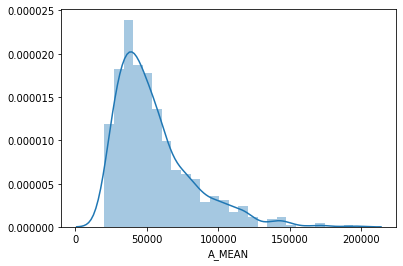

In [12]:
sns.distplot(df.A_MEAN)

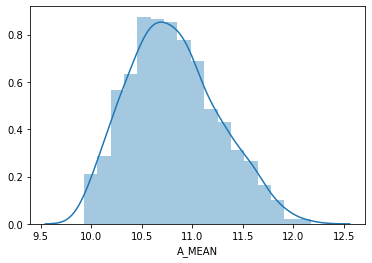

In [13]:
sns.distplot(np.log(df.A_MEAN))

## Median Annual Income

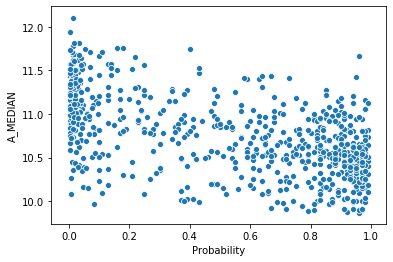

In [14]:
sns.scatterplot(df.Probability, np.log(df.A_MEDIAN))

In [15]:
# Test normality of wage
stat_wage_median, p_wage_median = normaltest(df.A_MEDIAN)
print('median wage is normally distributed') if p_wage_median < 0.01 else print('median wage is NOT normally distributed')

median wage is normally distributed


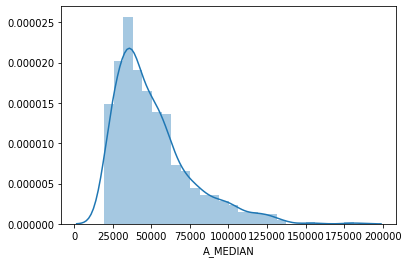

In [16]:
sns.distplot(df.A_MEDIAN)

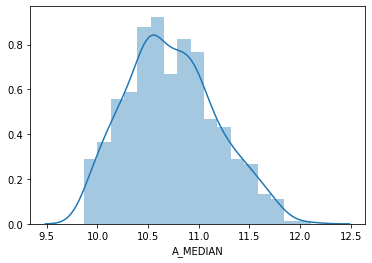

In [17]:
sns.distplot(np.log(df.A_MEDIAN))

# Data Analysis

In [18]:
df['log_A_MEAN'] = df.A_MEAN.apply(np.log)

In [19]:
outcome, predictors = patsy.dmatrices('Probability ~ log_A_MEAN', df)
model = sm.OLS(outcome, predictors)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Probability   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     329.2
Date:                Sat, 30 May 2020   Prob (F-statistic):           2.67e-60
Time:                        12:34:33   Log-Likelihood:                -150.83
No. Observations:                 682   AIC:                             305.7
Df Residuals:                     680   BIC:                             314.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6744      0.283     20.047      0.0

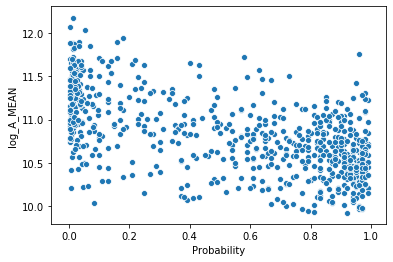

In [20]:
sns.scatterplot(df.Probability, df.log_A_MEAN)

## Model Analysis

In [21]:
def train_reg(X, Y):
    model = LinearRegression()
    model.fit(X, Y)
    return model

In [22]:
# Create separate predictors/outcomes set
df_model = df.dropna(subset=['log_A_MEAN'])
df_X = df_model[['log_A_MEAN']]
df_Y = df_model[['Probability']]

#df_X.dropna(inplace=True)
#df_Y.dropna(inplace=True)

In [23]:
# Seperate training and testing data
n_training = int(len(df_model)*0.8)

train_data_X = df_X[:n_training]
train_data_Y = df_Y[:n_training]
test_data_X = df_X[n_training:]
test_data_Y = df_Y[n_training:]

print("len(train_X): {}".format(len(train_data_X)))
print("len(train_Y): {}".format(len(train_data_Y)))
print("len(test_X): {}".format(len(test_data_X)))
print("len(train_Y): {}".format(len(test_data_Y)))

len(train_X): 545
len(train_Y): 545
len(test_X): 137
len(train_Y): 137


In [24]:
# Train models
reg_model = train_reg(train_data_X, train_data_Y)

In [25]:
# Test & analyze test data
df_predicted_test_Y_linreg = reg_model.predict(test_data_X)

print(reg_model.score(test_data_Y, df_predicted_test_Y_linreg))

-864.711028102047
